In [13]:
%load_ext autoreload
%autoreload 2

from exchange_data.data import OrderBookFrame
from exchange_data.data.backtest import Backtest
import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
params = {
 'cache': False,
 'database_name': 'binance_futures',
 'depth': 32,
 'futures': False,
 'group_by': '1m',
 'interval': '3d',
 'max_volume_quantile': 0.99,
 'offset_interval': '0h',
 'plot': False,
 'round_decimals': 2,
 'sequence_length': 48,
 'symbol': 'UNFIUSDT',
 'window_size': '1h',
 'additional_group_by': '10Min',
 'frame_width': 299
}

df = Backtest(**params).frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-11-25 20:32:39 INFO  [data.backtest:21] 
{'additional_group_by': '10Min',
 'cache': False,
 'database_name': 'binance_futures',
 'depth': 32,
 'frame_width': 299,
 'futures': False,
 'group_by': '1m',
 'interval': '3d',
 'max_volume_quantile': 0.99,
 'offset_interval': '0h',
 'plot': False,
 'round_decimals': 2,
 'sequence_length': 48,
 'symbol': 'UNFIUSDT',
 'window_size': '1h'}
2023-11-25 20:32:39 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-23 01:44:39.973976' AND time <= '2023-11-23 02:44:39.973976' GROUP BY time(1m);
2023-11-25 20:32:40 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-23 02:44:39.973976' AND time <= '2023-11-23 03:44:39.973976' GROUP BY time(1m);
2023-11-25 20:32:40 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-23 03:44:39.973976' AND time <= '2023-11-23 04:44:39.973976' G

In [14]:
df=df.loc[:, df.columns!='orderbook_img']
df

,best_ask,best_bid,prediction
time,,,
2023-11-23 02:30:00+00:00,10.726562,10.718750,0
2023-11-23 02:40:00+00:00,10.679688,10.679688,0
2023-11-23 02:50:00+00:00,10.671875,10.671875,0
2023-11-23 03:00:00+00:00,10.757812,10.757812,0
2023-11-23 03:10:00+00:00,10.843750,10.843750,0
...,...,...,...
2023-11-26 01:50:00+00:00,13.539062,13.539062,0
2023-11-26 02:00:00+00:00,13.484375,13.484375,0
2023-11-26 02:10:00+00:00,13.546875,13.546875,0


In [15]:
capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = None

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        next_row = df.iloc[ix + 1]
        best_ask = row['best_ask']
        
        if row['prediction'] == 1:
            if price_in == None:
                price_in = row['best_bid']
        else:
            if price_in:
                pnl = (best_ask - price_in) / price_in
                capital = capital + (capital * pnl)
                
            price_in = None
            
    #alog.info(capital)
    capital_ls.append(capital)

df['capital'] = np.asarray(capital_ls)

df

,best_ask,best_bid,prediction,capital
time,,,,
2023-11-23 02:30:00+00:00,10.726562,10.718750,0,1
2023-11-23 02:40:00+00:00,10.679688,10.679688,0,1
2023-11-23 02:50:00+00:00,10.671875,10.671875,0,1
2023-11-23 03:00:00+00:00,10.757812,10.757812,0,1
2023-11-23 03:10:00+00:00,10.843750,10.843750,0,1
...,...,...,...,...
2023-11-26 01:50:00+00:00,13.539062,13.539062,0,1
2023-11-26 02:00:00+00:00,13.484375,13.484375,0,1
2023-11-26 02:10:00+00:00,13.546875,13.546875,0,1


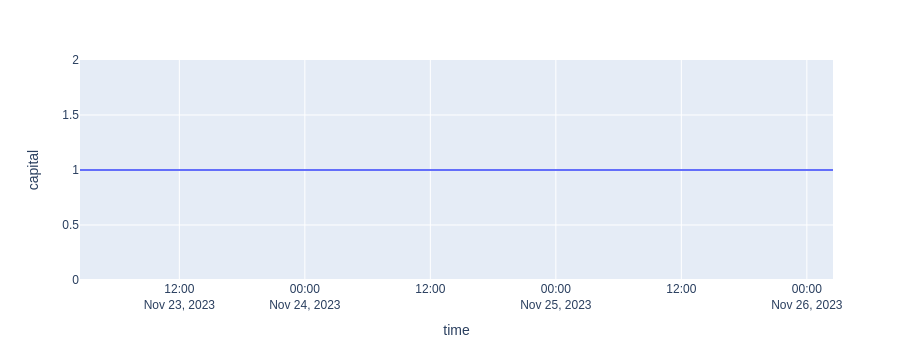

In [16]:
px.line(df, y='capital')